In [1]:
import importlib
import bike_route_choice

# Make changes to my_module.py

importlib.reload(bike_route_choice)

<module 'bike_route_choice' from 'c:\\Users\\aber\\Desktop\\bike_route_choice.py'>

In [2]:
from bike_route_choice import *

In [3]:
all_start_time = time.time()

In [4]:
cost_limit_mgra = 4
cost_limit_taz = 36

In [5]:
random_scale_coef = 0.5
random_scale_link = 0.7

In [6]:
num_iterations = 10

In [7]:
num_batches = 4
num_processors = 47

In [8]:
zone_level = 'mgra'
cost_limit = cost_limit_mgra

In [9]:
coef_dict = {}
with open(r'T:\ABM\user\aber\bike_route_choice\network\sandag_abm.properties','r') as properties:
    for line in properties:
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        key, value = line.split('=')
        key = key.strip()
        if key.startswith("active.coef."):
            _, name = key.split("active.coef.")
            coef_dict[name] = float(value)

In [10]:
nodes, edges, traversals = read_bike_network_data(zone_level=zone_level)

Reading network data from  T:\ABM\user\aber\bike_route_choice\network
Nodes: (154569, 7) Edges: (366199, 13) Traversals: (724008, 11)


In [11]:
edges = edges.drop(columns=['bikeCost','walkCost'])
edges['edgeCost'] = get_edge_cost(edges, coef_dict)

In [12]:
# # node mapping needs to start at 0 in order to create adjacency matrix
edge_mapping = edges[['fromNode','toNode']].reset_index()

# Get mgra centroids (nodes with 'centroid' flag True and 'mgra' greater than zero)
# Centroid connectors
origin_centroids = nodes[nodes['centroid'] & (nodes[zone_level] > 0)].merge(
    edge_mapping,
    how='left',
    left_on='id',
    right_on='fromNode'
)

null_cols = origin_centroids[origin_centroids.isnull().any(axis=1)]
if not null_cols.empty:
    print("WARNING: Null columns found in origin centroids dataframe! Dropping")
    print(null_cols)
    origin_centroids = origin_centroids.dropna()
    origin_centroids = origin_centroids.astype({'index': edge_mapping['index'].dtype})
    

origin_centroids = origin_centroids['index'].tolist()

dest_centroids = nodes[nodes['centroid'] & (nodes[zone_level] > 0)].merge(
    edge_mapping,
    how='left',
    left_on='id',
    right_on='toNode'
)

null_cols = dest_centroids[dest_centroids.isnull().any(axis=1)]
if not null_cols.empty:
    print("WARNING: Null columns found in destination centroids dataframe! Dropping")
    print(null_cols)
    dest_centroids = dest_centroids.dropna()
    dest_centroids = dest_centroids.astype({'index': edge_mapping['index'].dtype})

dest_centroids = dest_centroids['index'].tolist()

In [13]:
trace_od_df = pd.read_csv(r'T:\ABM\user\aber\bike_route_choice\network\trace_od.csv')
trace_od_df

,Origin,Destination
0,11164,11204


In [14]:
trace_od_df = trace_od_df.merge(nodes[['id',zone_level]], left_on='Origin', right_on=zone_level, how='left')
trace_od_df = trace_od_df.merge(nodes[['id',zone_level]], left_on='Destination', right_on=zone_level, how='left', suffixes=('_orig','_dest'))

In [15]:
trace_od_df

,Origin,Destination,id_orig,mgra_orig,id_dest,mgra_dest
0,11164,11204,100011164,11164,100011204,11204


In [16]:
trace_od_df = trace_od_df.merge(edge_mapping[['index','fromNode']], left_on='id_orig', right_on='fromNode', how='left')
trace_od_df = trace_od_df.merge(edge_mapping[['index','toNode']], left_on='id_dest', right_on='toNode', how='left', suffixes=('_orig','_dest'))

In [17]:
trace_od_df

,Origin,Destination,id_orig,mgra_orig,id_dest,mgra_dest,index_orig,fromNode,index_dest,toNode
0,11164,11204,100011164,11164,100011204,11204,339493,100011164,339574,100011204


In [18]:
trace_origins = []
trace_dests = []
try:
    trace_od_df = pd.read_csv(r'T:\ABM\user\aber\bike_route_choice\network\trace_od.csv')
    print(trace_od_df)

    trace_od_df = trace_od_df.merge(nodes[['id',zone_level]], left_on='Origin', right_on=zone_level, how='left')
    trace_od_df = trace_od_df.merge(nodes[['id',zone_level]], left_on='Destination', right_on=zone_level, how='left', suffixes=('_orig','_dest'))

    trace_od_df = trace_od_df.merge(edge_mapping[['index','fromNode']], left_on='id_orig', right_on='fromNode', how='left')
    trace_od_df = trace_od_df.merge(edge_mapping[['index','toNode']], left_on='id_dest', right_on='toNode', how='left', suffixes=('_orig','_dest'))

    trace_origins = trace_od_df['index_orig'].to_list()
    trace_dests = trace_od_df['index_dest'].to_list()
except:
    pass

   Origin  Destination
0   11164        11204


In [19]:
# Split origin centroids into batches
print(f'Splitting {len(origin_centroids)} origins into {num_batches} batches')
origin_centroid_batches = np.array_split(origin_centroids, num_batches)

Splitting 24320 origins into 4 batches


In [20]:
final_paths = []
for origin_centroid_batch in origin_centroid_batches:
    print(f'Splitting batch of {len(origin_centroid_batch)} origins into {num_processors} processes')
    origin_centroid_sub_batches = np.array_split(origin_centroid_batch, num_processors)
    with Pool(processes=num_processors) as pool:
        results = pool.starmap(run_batch_traversals, [(nodes, edges, traversals, origin_centroid_sub_batch, dest_centroids, cost_limit, num_iterations, coef_dict, random_scale_coef, random_scale_link, trace_origins, trace_dests) for origin_centroid_sub_batch in origin_centroid_sub_batches])
        final_paths.extend(results)

Splitting batch of 6080 origins into 47 processes
Splitting batch of 6080 origins into 47 processes
Splitting batch of 6080 origins into 47 processes
Splitting batch of 6080 origins into 47 processes


In [21]:
# for i in range(len(final_paths)):
#     list_i = list(final_paths[i])
#     for j in range(len(list_i)):
#         if list_i[j].shape[0] == 0:
#             list_i[j] = np.empty((0))
#     final_paths[i] = tuple(list_i)

In [22]:
final_paths_concat = map(np.concatenate,zip(*final_paths))
paths_od_orig_mapped, paths_od_dest_mapped, paths_od_logsum, trace_paths_orig_mapped, trace_paths_dest_mapped, trace_paths_iteration, trace_paths_prev_node, trace_paths_from_node, trace_paths_to_node, trace_paths_path_size = final_paths_concat

In [23]:
if trace_origins:
    trace_paths_df = pd.DataFrame({
        'origin': trace_paths_orig_mapped,
        'destination': trace_paths_dest_mapped,
        'iteration': trace_paths_iteration,
        'prev_node': trace_paths_prev_node,
        'from_node': trace_paths_from_node,
        'to_node': trace_paths_to_node,
        'path_size': trace_paths_path_size
    }, copy=False)

    # Mapped edge id to original node id
    trace_paths_df = trace_paths_df.merge(edge_mapping[['index','fromNode']],how='left',left_on='origin',right_on='index').drop(columns=['origin','index']).rename(columns={'fromNode':'origin'})
    trace_paths_df = trace_paths_df.merge(edge_mapping[['index','toNode']],how='left',left_on='destination',right_on='index').drop(columns=['destination','index']).rename(columns={'toNode':'destination'})

    trace_paths_df = trace_paths_df.merge(nodes[['id',zone_level]],how='left',left_on='origin',right_on='id')
    trace_paths_df = trace_paths_df.merge(nodes[['id',zone_level]], how='left', left_on = 'destination', right_on = 'id', suffixes = ('_orig','_dest'))

    # Mapped noded id to original node id
    rev_node_mapping = dict(enumerate(nodes.id))
    rev_node_mapping[-1] = -1
    trace_paths_df['prev_node'] = trace_paths_df['prev_node'].map(rev_node_mapping)
    trace_paths_df['from_node'] = trace_paths_df['from_node'].map(rev_node_mapping)
    trace_paths_df['to_node'] = trace_paths_df['to_node'].map(rev_node_mapping)
    trace_paths_df = trace_paths_df.merge(edges, left_on=('from_node','to_node'), right_on=('fromNode','toNode'), how='left')
    trace_paths_df = trace_paths_df.merge(traversals, left_on=('prev_node','from_node','to_node'), right_on=('start','thru','end'), how='left')

    # print(trace_paths_df)


In [24]:
trace_paths_df

,iteration,prev_node,from_node,to_node,path_size,origin,destination,id_orig,mgra_orig,id_dest,...,thru,end,turnType,bikecost,thruCentroid,signalExclRight,unlfrma,unlfrmi,unxma,unxmi
0,0.0,100011164,888411,890241,0.124150,100011164,100011204,100011164,11164,100011204,...,888411.0,890241.0,0.0,0.000,False,False,False,False,False,False
1,0.0,888411,890241,892481,0.124150,100011164,100011204,100011164,11164,100011204,...,890241.0,892481.0,0.0,0.000,False,False,False,False,False,False
2,0.0,890241,892481,893751,0.124150,100011164,100011204,100011164,11164,100011204,...,892481.0,893751.0,0.0,0.000,False,False,False,False,False,False
3,0.0,892481,893751,895361,0.124150,100011164,100011204,100011164,11164,100011204,...,893751.0,895361.0,0.0,0.000,False,False,False,False,False,False
4,0.0,893751,895361,893931,0.124150,100011164,100011204,100011164,11164,100011204,...,895361.0,893931.0,2.0,0.083,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,5.0,-1,100011164,888411,0.332243,100011164,100011204,100011164,11164,100011204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,6.0,-1,100011164,888411,0.124150,100011164,100011204,100011164,11164,100011204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,7.0,-1,100011164,888411,0.124150,100011164,100011204,100011164,11164,100011204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185,8.0,-1,100011164,888411,0.124150,100011164,100011204,100011164,11164,100011204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
trace_paths_df.columns

Index(['iteration', 'prev_node', 'from_node', 'to_node', 'path_size', 'origin',
       'destination', 'id_orig', 'mgra_orig', 'id_dest', 'mgra_dest',
       'fromNode', 'toNode', 'bikeClass', 'lanes', 'functionalClass',
       'centroidConnector', 'autosPermitted', 'cycleTrack', 'bikeBlvd',
       'distance', 'gain', 'edgeCost', 'start', 'thru', 'end', 'turnType',
       'bikecost', 'thruCentroid', 'signalExclRight', 'unlfrma', 'unlfrmi',
       'unxma', 'unxmi'],
      dtype='object')

In [26]:
print("Converting to pandas dataframe...")
paths_df = pd.DataFrame({
    'origin': paths_od_orig_mapped,
    'destination': paths_od_dest_mapped,
    'logsum': paths_od_logsum,
}, copy=False)

Converting to pandas dataframe...


In [27]:
# Mapped edge id to original node id
paths_df = paths_df.merge(edge_mapping,how='left',left_on='origin',right_on='index')[['fromNode','destination','logsum']].rename(columns={'fromNode':'origin'})
paths_df = paths_df.merge(edge_mapping,how='left',left_on='destination',right_on='index')[['origin','toNode','logsum']].rename(columns={'toNode':'destination'})

In [28]:
paths_df = paths_df.merge(nodes[['id',zone_level]],how='left',left_on='origin',right_on='id').drop(columns='id')
paths_df = paths_df.merge(nodes[['id',zone_level]], how='left', left_on = 'destination', right_on = 'id', suffixes = ('_orig','_dest')).drop(columns='id')

In [ ]:
# paths_df = paths_df[paths_df.mgra_orig != paths_df.mgra_dest]

In [30]:
trace_paths_df['cost_total'] = trace_paths_df['edgeCost'] + trace_paths_df['bikecost']

Plotting the shortest path...


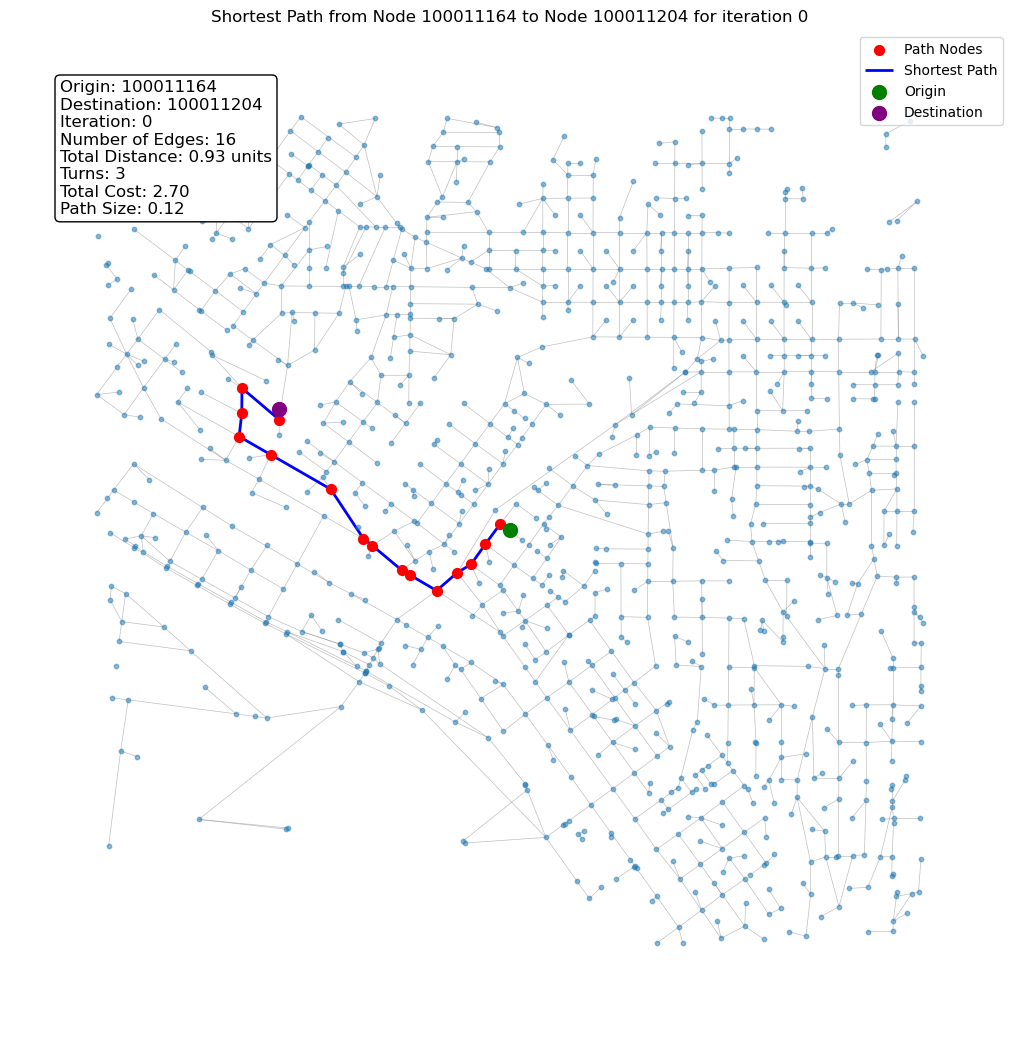

Plotting the shortest path...


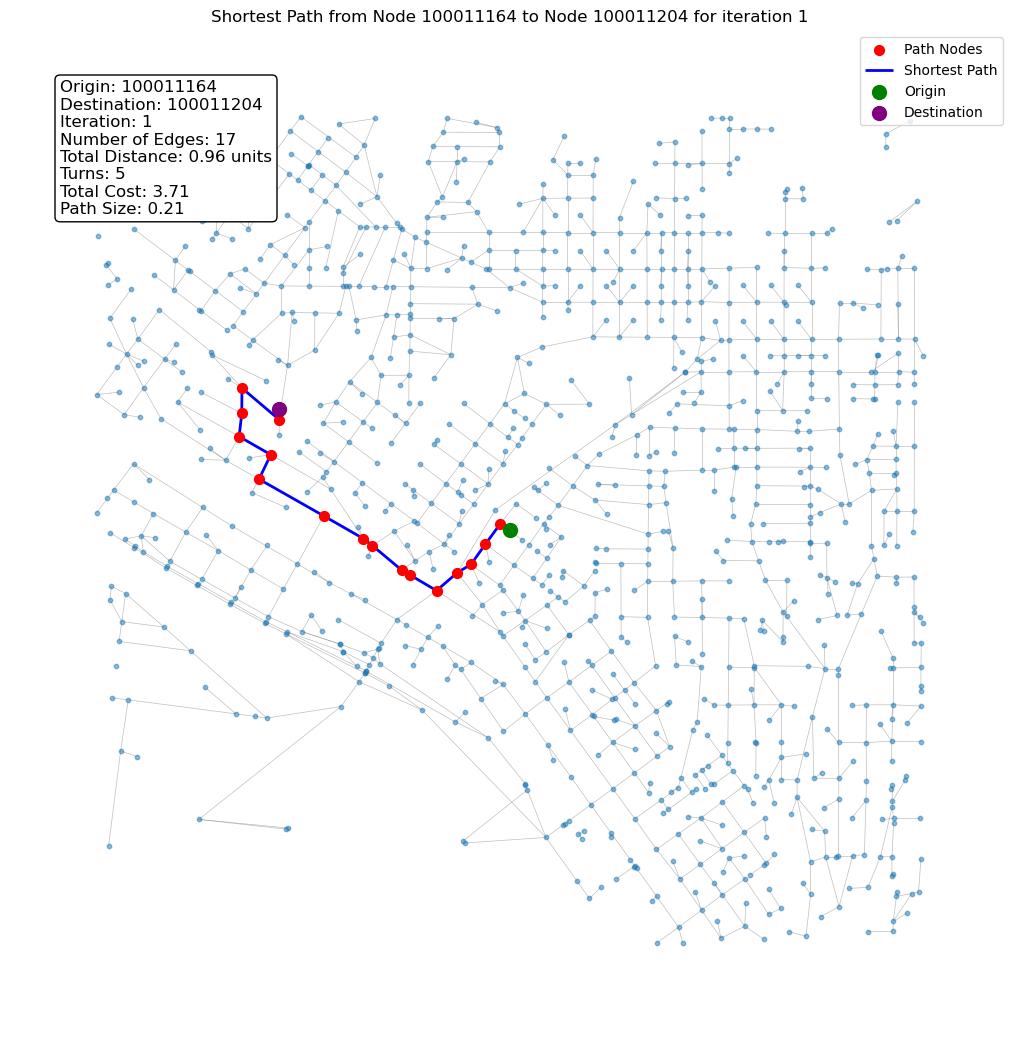

Plotting the shortest path...


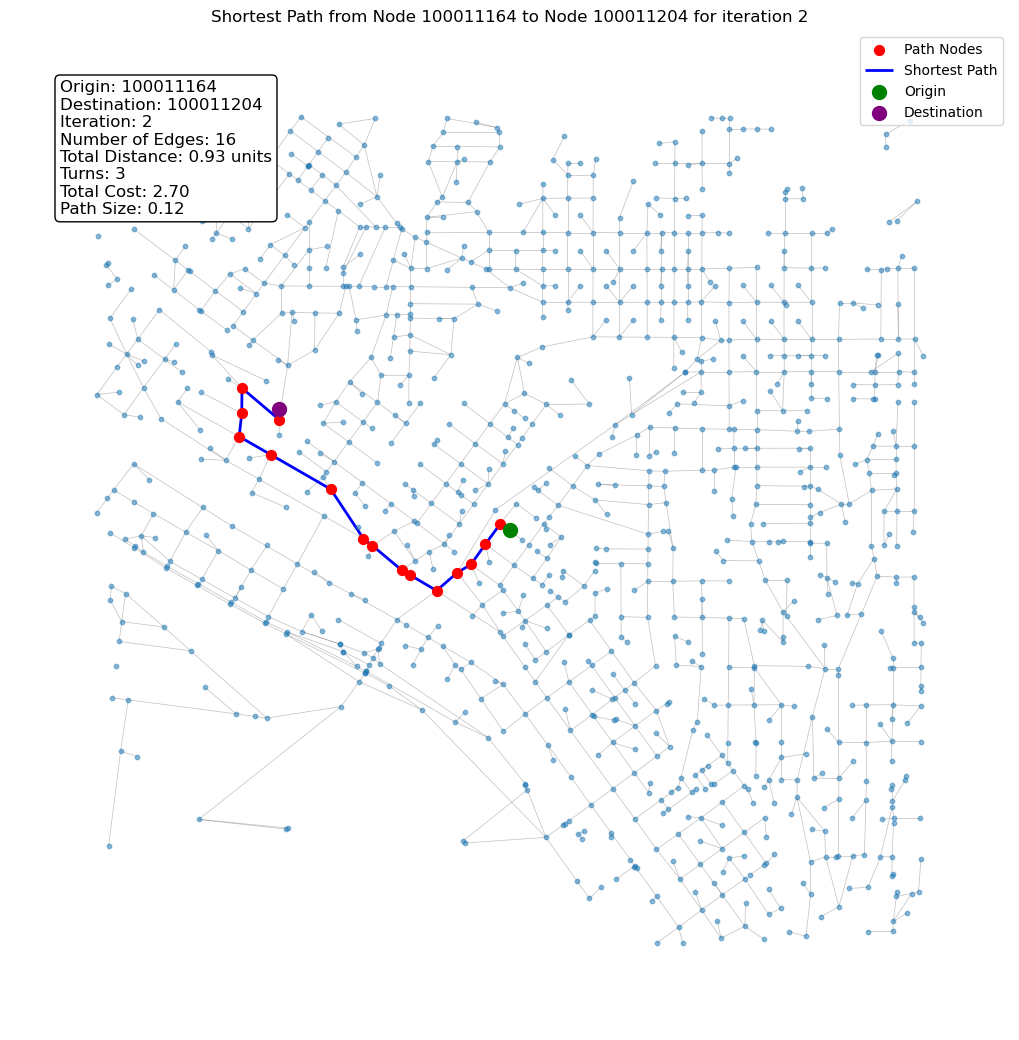

Plotting the shortest path...


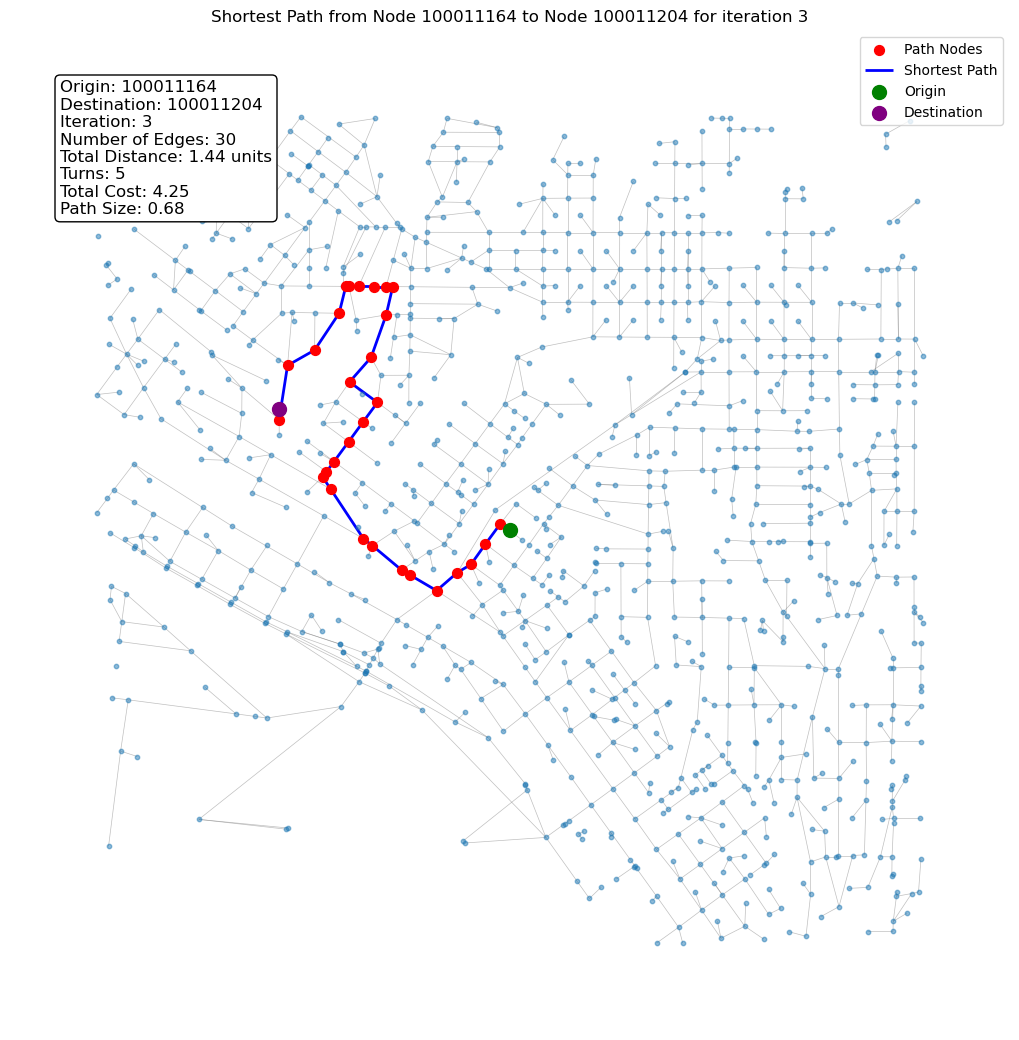

Plotting the shortest path...


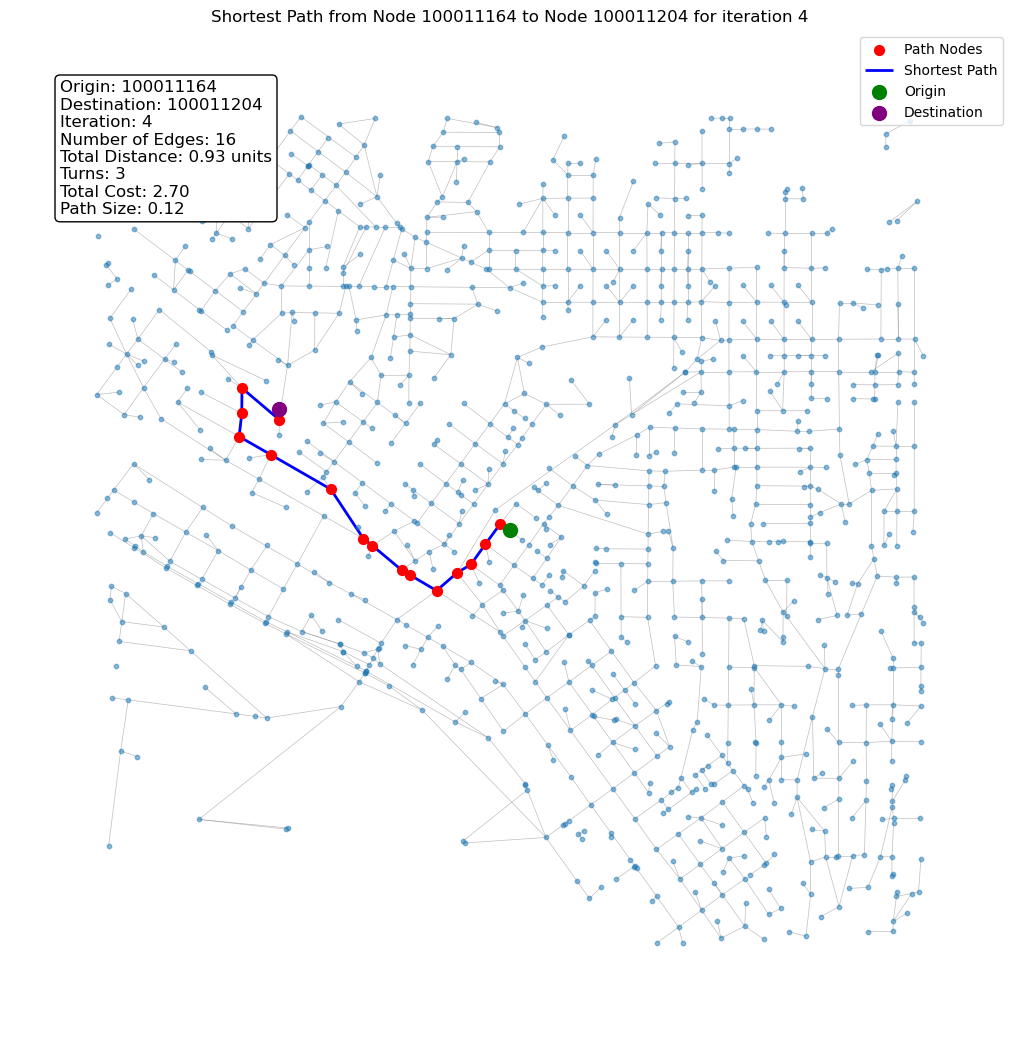

Plotting the shortest path...


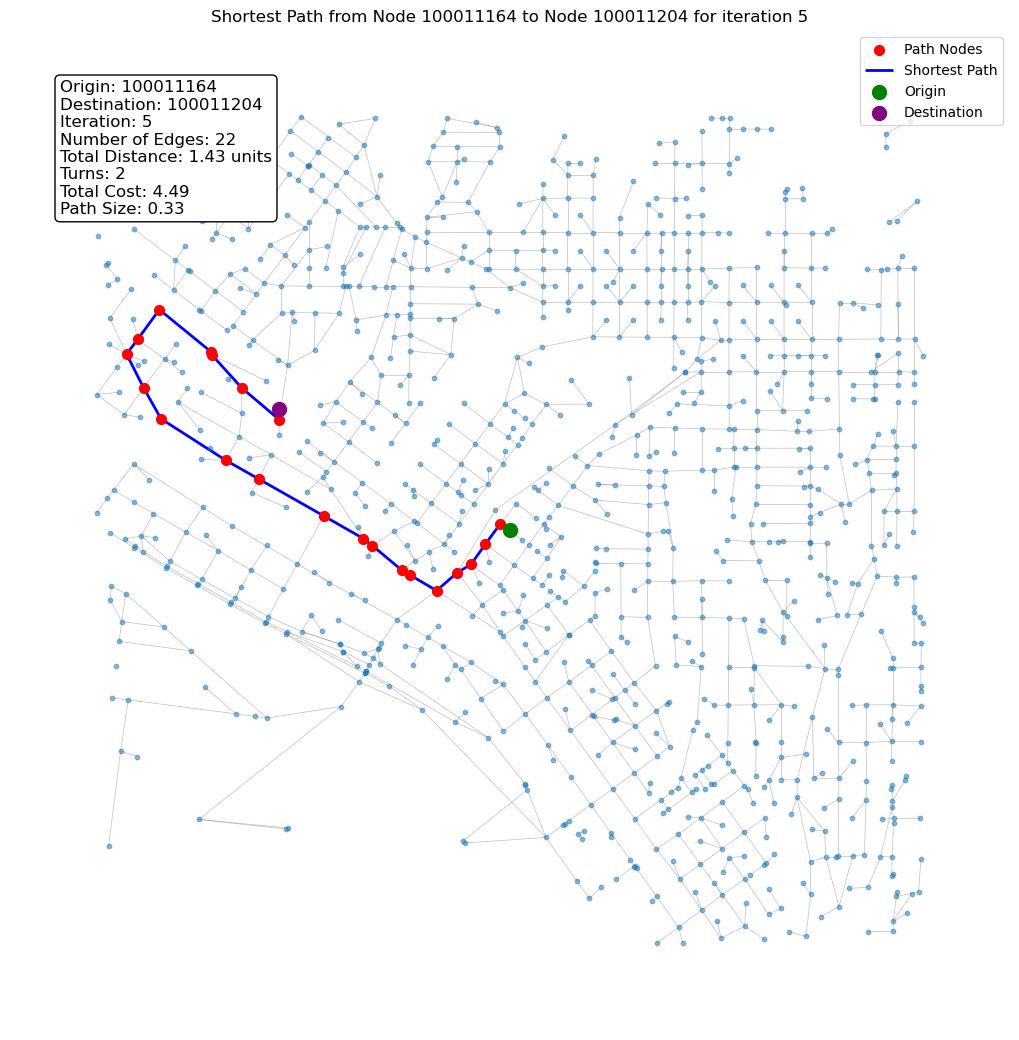

Plotting the shortest path...


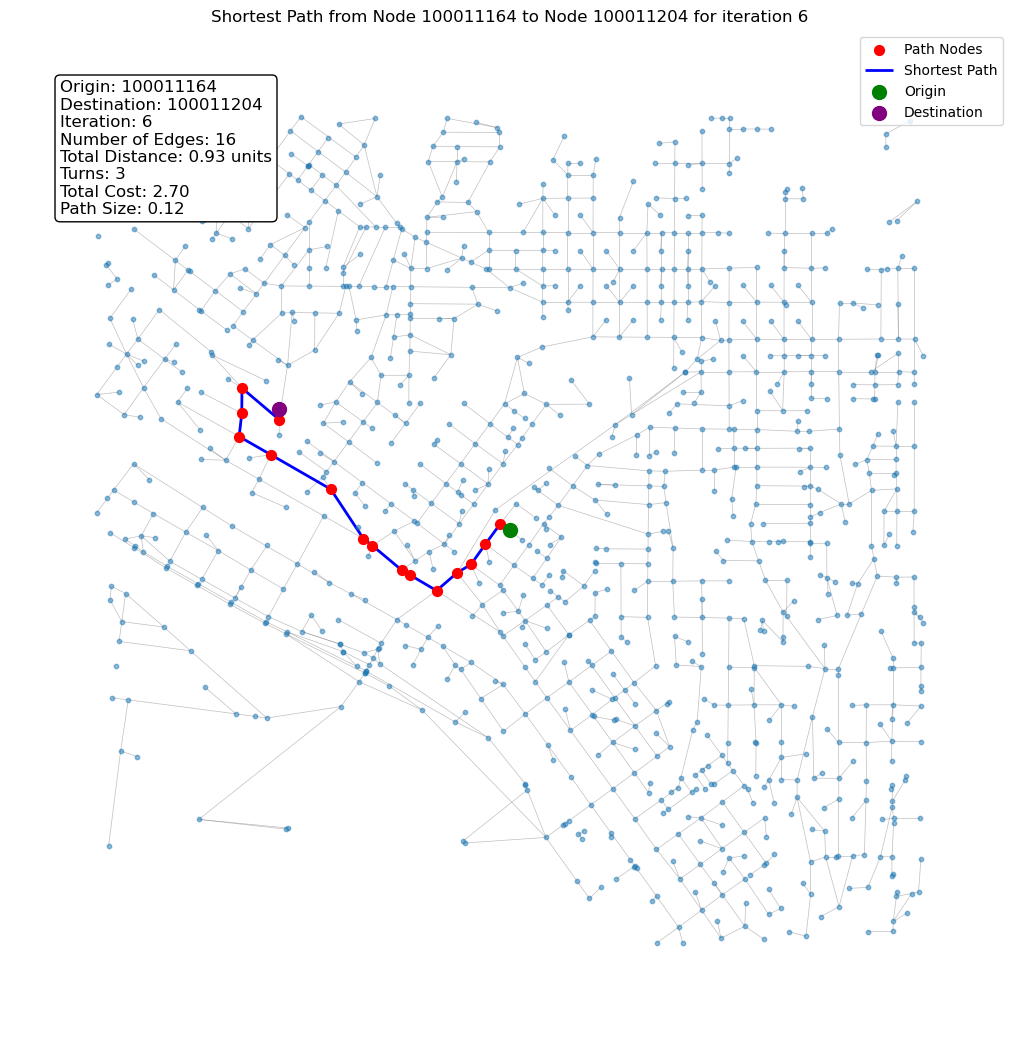

Plotting the shortest path...


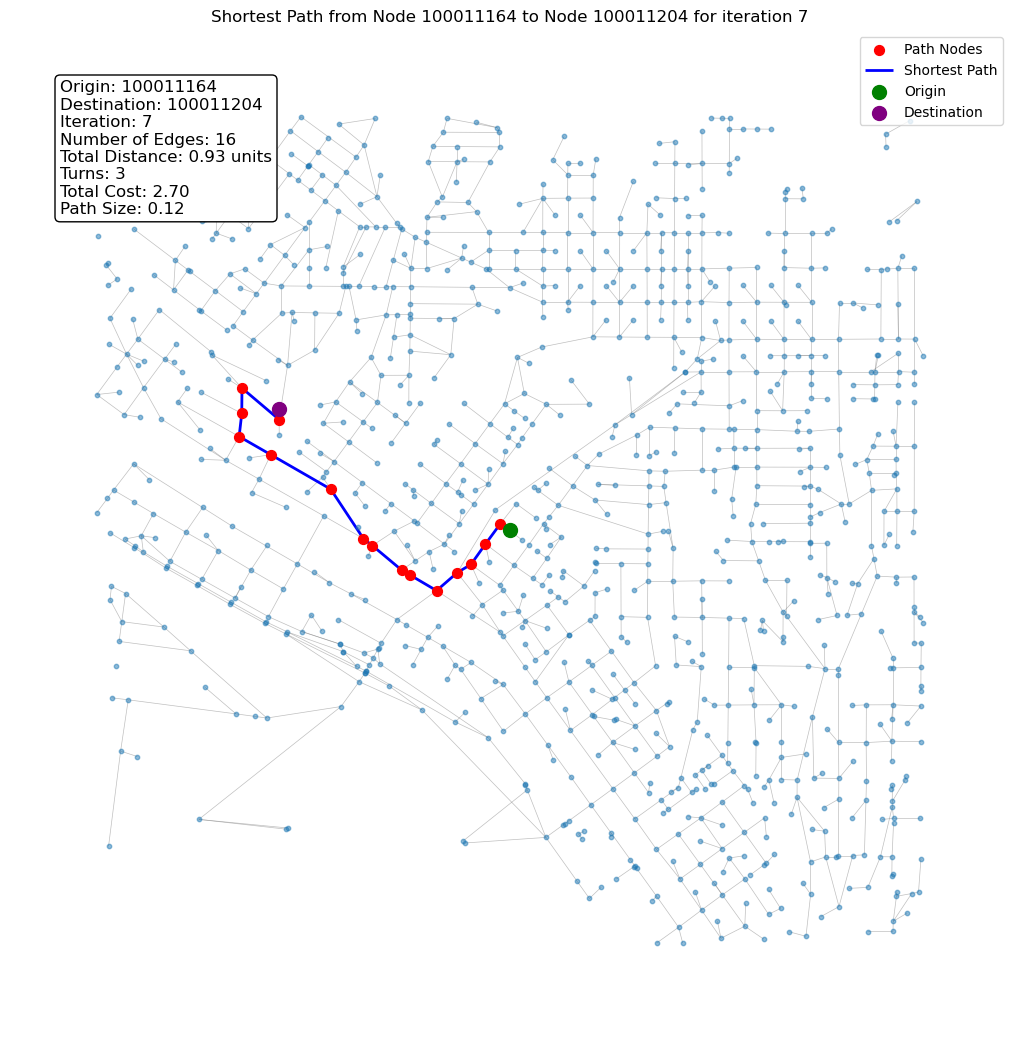

Plotting the shortest path...


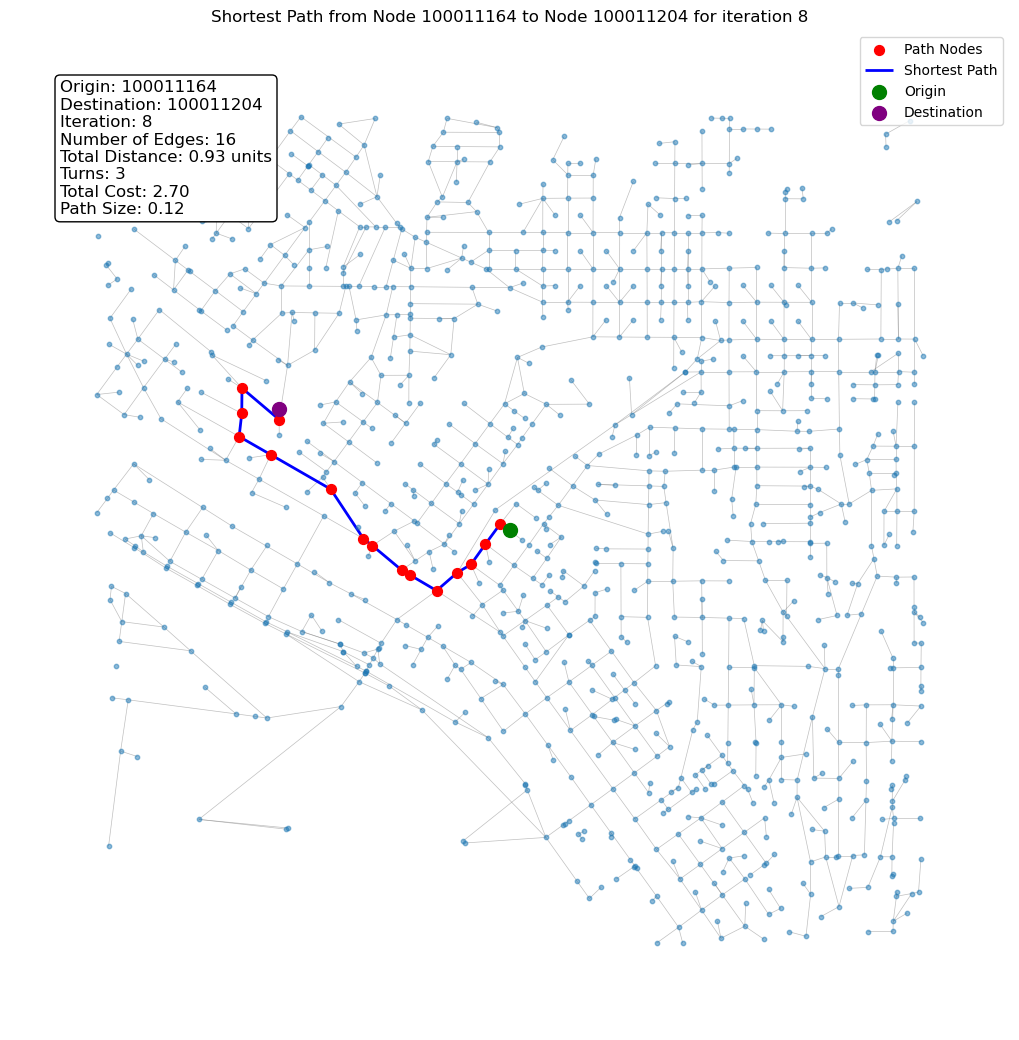

Plotting the shortest path...


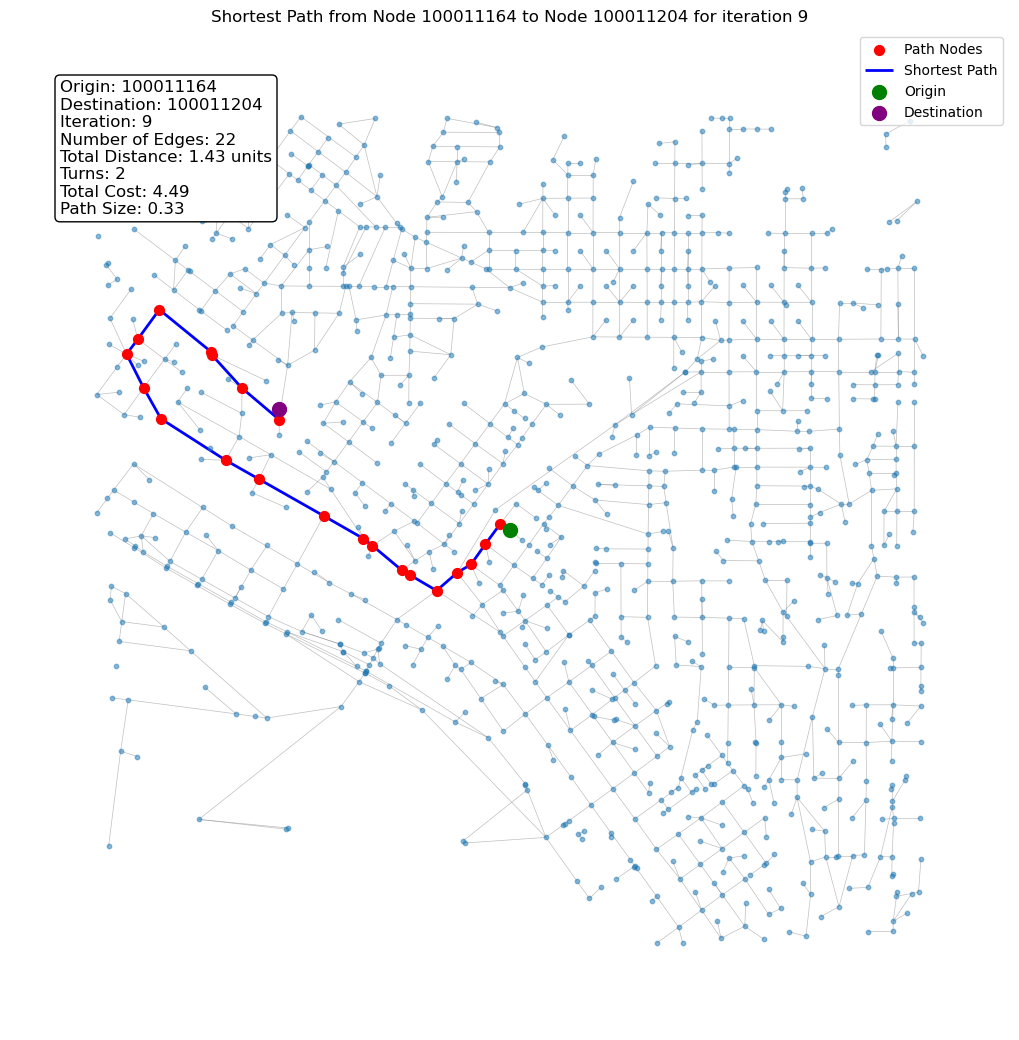

In [31]:
for _, row in trace_od_df.iterrows():
    origin = row['id_orig']
    destination = row['id_dest']
    for iteration in range(num_iterations):
        plot_shortest_path_with_results_buffered(nodes, edges, trace_paths_df, origin, destination, iteration, buffer_size=(5280/5)*cost_limit)

In [32]:
# paths_df[['mgra_orig','mgra_dest','logsum']].rename(columns={'mgra_orig':'i','mgra_dest':'j'}).to_csv(r'C:\Users\aber\Desktop\bikeTazLogsum_python_10paths_4batch_47proc_traversals_stochastic.csv')

In [33]:
paths_df

,origin,destination,logsum,mgra_orig,mgra_dest
1,100000001,100000022,-8.322686,1,22
2,100000001,100000038,-7.999672,1,38
3,100000001,100000062,-7.344052,1,62
4,100000001,100000071,-7.665487,1,71
5,100000001,100000089,-6.670106,1,89
...,...,...,...,...,...
11914556,100024321,100023671,-5.552878,24321,23671
11914557,100024321,100023672,-5.165583,24321,23672
11914558,100024321,100023728,-5.156648,24321,23728
11914559,100024321,100024224,-3.700765,24321,24224


In [34]:
all_end_time = time.time()
all_elapsed_time = all_end_time - all_start_time
print(f"Total time taken: {all_elapsed_time:.2f} seconds")

Total time taken: 471.79 seconds
